# Import the libraries for CNN ML

In [33]:
#import the libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image

# Read the Image Data

To begin with, we are required to read the image data in order to train our CNN Model. Consider the given dataset, it seems the dataset should be a relatively small one where 4 classes of RGB images are present, which are apple, banana, orange and mixed. In order to design a CNN which would be able to classify the images into the respective classes, feature value of dataset is the first thing we need to take into consideration. As we analyze, there are 4 features that can distinguish the images.  

1. Color Feature  

    - Main peaks of the color histogram: represent the most prominent colors for each fruit.
    - Average color value: can be used to differentiate fruits with different colors (e.g., oranges from apples).  
    
2. Shape Feature  

    - Aspect ratio: Useful for distinguishing elongated fruits like bananas from round ones like apples or oranges.
    - Geometric shape descriptors: Includes contour-based features like length and area.

3. Size Features:  

    - Region size: Indicates the number of pixels occupied by the fruit, calculated using thresholding and contour detection.

4. Texture Features(Optional):  

    - Texture intensity: Quantified using contrast and uniformity from the Gray-Level Co-occurrence Matrix (GLCM).

Even though CNN does not have a problem with the feature values, it is not a good idea to use the feature values directly as the input to the CNN. The reason is that the feature values are not in the same scale, and the CNN is sensitive to the input values. It would be a reference to design whether our CNN model is designed wrong or not.

In [34]:
def read_img_data(path, img_width, img_height):
    filepaths = []
    labels = []
    images = []
    sizes = []

    # Load all the filenames and labels
    for file in os.listdir(path):
        if file.startswith('.'):
            continue
        filepath = os.path.join(path, file)
        try:
            img = Image.open(filepath)
            # retrive the size of the image
            original_size = img.size
            img = img.convert('RGBA')
            # Convert the image to RGB if it's not already in that format
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img = img.resize((img_width, img_height))
            img_array = np.array(img)
            # Ensure all images have the same shape (256, 256, 3)
            if img_array.shape == (img_height, img_width, 3):
                label = file.split('_')[0]
                images.append(img_array)
                labels.append(label)
                filepaths.append(filepath)
                sizes.append((label, original_size))
            else:
                print(f"Image {file} has an inconsistent shape: {img_array.shape}")
        except Exception as e:
            print(f"Error loading image {file}: {e}")

    # Convert the image data to a NumPy array, set the unique labels
    unique_labels = set(labels)
    images = np.array(images)

    
    print("Size of the dataset: {} images".format(len(images)))
    print("Distribution of labels: {}".format({label: labels.count(label) for label in unique_labels}))
    plot_dataset_count(labels, unique_labels)
    plot_dataset_size(sizes, label, unique_labels)

    return images, labels, unique_labels

def plot_dataset_count(labels, unique_labels):
    # Plot the distribution of labels in the dataset
    label_counts={label: 0 for label in unique_labels}
    print(unique_labels)
    # Create a fixed color palette for consistent plotting
    fixed_colors = np.array([[1.0, 0.0, 0.0],  # Red
                         [1.0, 0.5, 0.0],  # Orange
                         [1.0, 1.0, 0.0],  # Yellow
                         [0.0, 1.0, 0.0]])  # Green
    # Generate random colors for the remaining labels
    random_colors = np.random.rand(len(label_counts) - 4, 3)
    # Combine the fixed and random colors into a single array
    colors = np.vstack((fixed_colors, random_colors))

    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1
    
    labels_unique = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(6, 4))
    plt.bar(labels_unique, counts, color=colors)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels in Dataset')
    plt.show()

def plot_dataset_size(sizes, label, unique_labels):
    size_dict = {label: [] for label in unique_labels}
    for label, size in sizes:
        size_dict[label].append(size)
    
    avg_sizes = {}
    for label in unique_labels:
        widths, heights = zip(*size_dict[label])
        avg_width = sum(widths) / len(widths)
        avg_height = sum(heights) / len(heights)
        avg_sizes[label] = (avg_width, avg_height)

    # Plot the distribution of image sizes in the dataset
    plt.figure(figsize=(10, 4))
    for i, label in enumerate(unique_labels):
        label_sizes = size_dict[label]
        if label_sizes:
            x, y = zip(*label_sizes)
            plt.scatter(x, y, label=label)

            # Plot the average point for each label
            avg_x, avg_y = avg_sizes[label]
            plt.scatter(avg_x, avg_y, color='black', marker='x', s=100)
    
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.title('Size Distribution of Images in Each Category with Average Points')
    plt.legend()
    plt.show()

    widths = {label: [size[0] for size in sizes] for label, sizes in size_dict.items()}
    heights = {label: [size[1] for size in sizes] for label, sizes in size_dict.items()}

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # Widths of each category
    for i, label in enumerate(unique_labels):
        axes[0].boxplot(widths[label], positions=[i+1], widths=0.6, patch_artist=True)
    axes[0].set_xticks(range(1, len(unique_labels) + 1))
    axes[0].set_xticklabels(unique_labels)
    axes[0].set_title('Widths of Each Category')
    axes[0].set_ylabel('Width (pixels)')

    # Heights of each category
    for i, label in enumerate(unique_labels):
        axes[1].boxplot(heights[label], positions=[i+1], widths=0.6, patch_artist=True)
    axes[1].set_xticks(range(1, len(unique_labels) + 1))
    axes[1].set_xticklabels(unique_labels)
    axes[1].set_title('Heights of Each Category')
    axes[1].set_ylabel('Height (pixels)')

    plt.tight_layout()
    plt.show()

# Analyze the Data
Since we have a large dataset, we will use the following function to analyze the dataset. For CNN, we don't need to give exact feature value, but we would like to consider whether the classification would be accurate. So we would analyze the dataset to see if there is any bias in the dataset. This function analyzes the dataset by calculating and displaying the average color of images for each label. It creates a subplot arrangement based on the number of unique labels, calculates the average color for each label, and plots a bar chart for the average color in each subplot.

In [35]:
def analyze_dataset_color(images, labels, unique_labels):
    label_colors = {}
    
    # Define the arrangement of the subplots. For example, if there are 4 labels, you can choose a 2x2 arrangement.
    num_labels = len(unique_labels)
    num_cols = int(np.sqrt(num_labels))
    num_rows = num_labels // num_cols + (num_labels % num_cols > 0)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6, 4))

    # Make sure axs is always two-dimensional, for easier indexing
    if num_labels == 1:
        axs = [axs]
    axs = np.array(axs).reshape(num_rows, num_cols)

    # Calculate the average color for each label
    for idx, label in enumerate(unique_labels):
        label_images = images[np.where(np.array(labels) == label)]
        avg_color = np.mean(label_images, axis=(0, 1, 2))
        label_colors[label] = avg_color

        # Locate the subplot for the label and plot its color
        row, col = idx // num_cols, idx % num_cols
        ax = axs[row, col]

        # Plot the color in the appropriate subplot
        ax.bar(['Red', 'Green', 'Blue'], avg_color, color=['r', 'g', 'b'])
        ax.set_title(f'{label}')
        ax.set_ylabel('Intensity')

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()

def analyze_dataset_color_histogram(images, labels, unique_labels):
    # Initialize histograms structure
    histograms = {label: {channel: [] for channel in ['r', 'g', 'b']} for label in unique_labels}

    # Compute histograms for each category
    for img, label in zip(images, labels):
        for channel in range(3):
            channel_hist = np.histogram(img[:, :, channel], bins=256, range=(0, 256))[0]
            histograms[label]['rgb'[channel]].append(channel_hist)

    # Calculate average histograms
    avg_histograms = {label: {channel: np.mean(histograms[label][channel], axis=0)
                              for channel in ['r', 'g', 'b']}
                      for label in unique_labels}

    # Determine the layout for subplots based on the number of unique labels
    num_unique_labels = len(unique_labels)
    
    # Create subplots - one subplot for each unique label
    fig, axes = plt.subplots(nrows=num_unique_labels, ncols=1, figsize=(6, 3 * num_unique_labels), constrained_layout=True)

    # If there's only one label, wrap the axes in a list for consistent indexing
    if num_unique_labels == 1:
        axes = [axes]

    # Plot average histograms for each category in separate subplots
    for idx, label in enumerate(unique_labels):
        num_images = len(histograms[label]['r'])
        for channel, color in zip(['r', 'g', 'b'], ['red', 'green', 'blue']):
            # Normalizing the histogram by the number of images to get the average pixel count
            axes[idx].plot(avg_histograms[label][channel] / num_images, color=color, label=f'{channel.upper()} channel')
            # Mark the peak of the average histogram
            peak = np.argmax(avg_histograms[label][channel])
            axes[idx].plot(peak, avg_histograms[label][channel][peak] / num_images, 'o', color=color)
            axes[idx].set_title(f'Average RGB Histogram for {label}')
            axes[idx].set_xlabel('Intensity Value')
            axes[idx].set_ylabel('Average Number of Pixels per Image')
            axes[idx].legend()

    # Show the plot
    plt.show()

def analyze_dataset_color_histogram_non_white(images, labels, unique_labels):
    # Initialize histograms structure
    histograms = {label: {channel: [] for channel in ['r', 'g', 'b']} for label in unique_labels}

    # Compute histograms for each category
    for img, label in zip(images, labels):
        # Create a mask for non-white pixels
        non_white_mask = ~(np.all(img == [255, 255, 255], axis=-1))

        for channel in range(3):
            # Apply the mask to filter out the white pixels for each channel
            filtered_img_channel = img[..., channel][non_white_mask]
            # Compute the histogram for non-white pixels of this channel
            channel_hist = np.histogram(filtered_img_channel, bins=256, range=(0, 255))[0]
            histograms[label]['rgb'[channel]].append(channel_hist)

    # Calculate average histograms
    avg_histograms = {label: {channel: np.mean(histograms[label][channel], axis=0)
                              for channel in ['r', 'g', 'b']}
                      for label in unique_labels}

    # Determine the layout for subplots based on the number of unique labels
    num_unique_labels = len(unique_labels)
    
    # Create subplots - one subplot for each unique label
    fig, axes = plt.subplots(nrows=num_unique_labels, ncols=1, figsize=(6, 3 * num_unique_labels), constrained_layout=True)

    # If there's only one label, wrap the axes in a list for consistent indexing
    if num_unique_labels == 1:
        axes = [axes]

    # Plot average histograms for each category in separate subplots
    for idx, label in enumerate(unique_labels):
        for channel, color in zip(['r', 'g', 'b'], ['red', 'green', 'blue']):
            # Normalizing the histogram by the number of images to get the average pixel count
            axes[idx].plot(avg_histograms[label][channel], color=color, label=f'{channel.upper()} channel')
            # Mark the peak of the average histogram
            peak = np.argmax(avg_histograms[label][channel])
            axes[idx].plot(peak, avg_histograms[label][channel][peak], 'o', color=color)
            axes[idx].set_title(f'Average RGB Histogram without White Pixels for {label}')
            axes[idx].set_xlabel('Intensity Value')
            axes[idx].set_ylabel('Average Pixel Count')
            axes[idx].legend()

    # Show the plot
    plt.show()

from matplotlib import cm

def analyze_dataset_color_3D(images, labels, unique_labels):
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111, projection='3d')

    # Generate a color map for the labels
    color_map = cm.get_cmap('rainbow', len(unique_labels))
    label_to_color = {label: color_map(i) for i, label in enumerate(unique_labels)}

    # Go through each image and plot its color on the 3D scatter plot
    for img, label in zip(images, labels):
        color = label_to_color[label]
        ax.scatter(img[:, :, 0].mean(), img[:, :, 1].mean(), img[:, :, 2].mean(), color=color)

    # Seperatly plot the average color for each label
    for label, color in label_to_color.items():
        ax.scatter([], [], [], color=color, label=label)

    # Set the legend
    ax.set_xlabel('Red Intensity')
    ax.set_ylabel('Green Intensity')
    ax.set_zlabel('Blue Intensity')
    ax.set_title('Average Color of Images in Dataset')
    ax.legend()

    plt.show()

# Encode the data

In [36]:
def encode_onehot(label_idx, num_classes):
    onehot_encoded = np.zeros(num_classes)
    onehot_encoded[label_idx] = 1
    return onehot_encoded

# Prepare the Data

In [37]:
def prep_data(images, labels, unique_labels):
    x = images
    y = []

    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    for label in labels:
        label_index = label_to_index[label]
        y_onehot = encode_onehot(label_index, len(unique_labels))
        y.append(y_onehot)

    return np.array(x), np.array(y)

# Train the Model

In [38]:
def train_model(model, x_train, y_train, x_test, y_test):
    history = model.fit(x=x_train/255, y=y_train, epochs=15, validation_data=(x_test/255, y_test))
    fig = plt.figure(num=1, figsize=(14,6))
    
    ax1 = fig.add_subplot(211)   
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    
    ax2 = fig.add_subplot(212)
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy Curve')
    
    plt.show()    

# Create the Model


To create an effective Convolutional Neural Network (CNN) for our task, we need to carefully consider the network's depth and the number of layers. The depth of a neural network has a profound impact on its performance and training process.  

When it comes to network depth, striking the right balance is crucial. Too few layers can lead to underfitting, where the model fails to capture complex patterns and features in the data, resulting in high training and validation errors. Shallow networks are limited in their ability to learn abstract features beyond edges and textures.  

Conversely, having too many layers can lead to overfitting, where the model performs well on the training data but poorly on unseen data. Training deep networks can be challenging due to the vanishing gradient problem, which may require the use of advanced techniques like batch normalization and residual connections.  

To determine the optimal number of layers, we should consider the complexity of the task and the size of the dataset. For simpler tasks and smaller datasets, shallower networks may suffice. In contrast, complex tasks and large datasets may benefit from deeper networks capable of learning higher-level features.  

Regularization techniques like dropout and normalization can help mitigate overfitting, making it easier to experiment with deep networks. Additionally, leveraging pretrained models through transfer learning can provide a solid starting point, allowing us to fine-tune the number of layers to suit our specific task.  

In our specific model design, we start with the first layer containing 32 convolutional kernels. This is a reasonable starting point because the initial layers primarily capture simple features like edges and corners. As the network's depth increases, we may increase the number of convolutional kernels, such as to 64. This helps the network learn more complex features as the abstraction level rises with depth.  

Following one or more convolutional layers, we typically include a pooling layer, such as MaxPooling. Its role is to reduce the spatial size of the feature maps, enhance feature invariance, and reduce the number of parameters and computational load.  

In summary, creating an effective CNN involves carefully balancing the network's depth and layer complexity, considering the task, dataset size, and applying appropriate regularization techniques. This approach ensures that our model can capture both simple and complex features while avoiding common pitfalls like underfitting and overfitting.  

In [39]:
def create_model():
    model = tf.keras.Sequential()

    # create a CNN model
    # add the first convolutional layer. Since it is the first layer, the filters parameter will be slowly increased from 32 to 256
    model.add(tf.keras.layers.Conv2D(filters=32,
        kernel_size=(3, 3), activation='relu', input_shape=(256,256,3)))
    # add the max pooling layer to reduce the size of the feature maps
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # add the dropout layer. This layer is used to prevent overfitting

    # add the second convolutional layer. The number of filters is increased to 64
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # add the third convolutional layer. The number of filters is increased to 128
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # add the fourth convolutional layer. The number of filters is increased to 256
    model.add(tf.keras.layers.Conv2D(filters=256,
        kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # add the fifth convolutional layer. The number of filters is increased to 512
    #model.add(tf.keras.layers.Conv2D(filters=512,
    #    kernel_size=(3, 3), activation='relu'))
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Dropout(0.2))

    # add the flatten layer to convert the 2D feature maps to a 1D feature vector
    model.add(tf.keras.layers.Flatten())

    # add the first dense layer. The number of neurons will influence whether the model can learn complex relationships in the dataset
    model.add(tf.keras.layers.Dense(units=1024, activation='relu'))    
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(units=4, activation='softmax'))    

    # build the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                    metrics=['accuracy'])

    return model

# Main Program

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 30, 30, 128)     

None
Size of the dataset: 240 images
Distribution of labels: {'apple': 75, 'mixed': 20, 'banana': 73, 'orange': 72}
{'apple', 'mixed', 'banana', 'orange'}


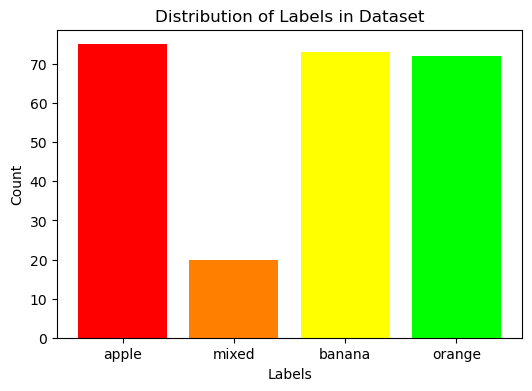

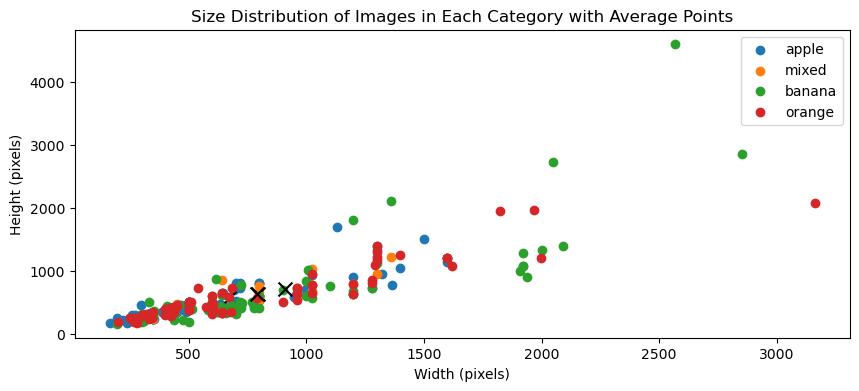

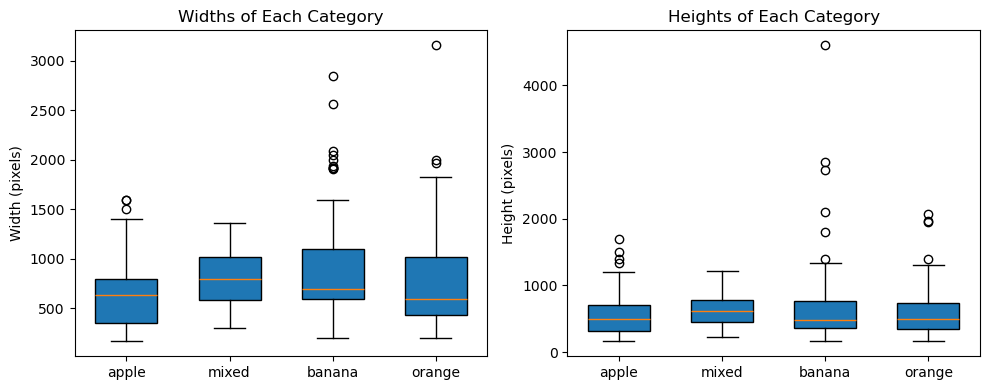

Color Analysis


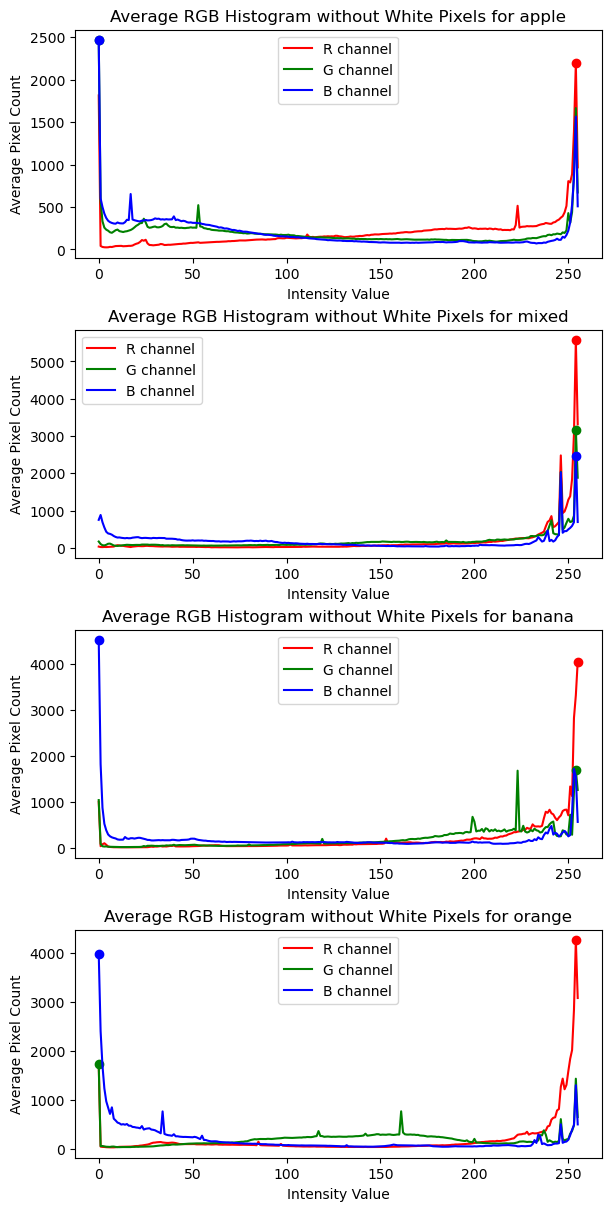

Size of the dataset: 60 images
Distribution of labels: {'apple': 19, 'mixed': 5, 'banana': 18, 'orange': 18}
{'apple', 'mixed', 'banana', 'orange'}


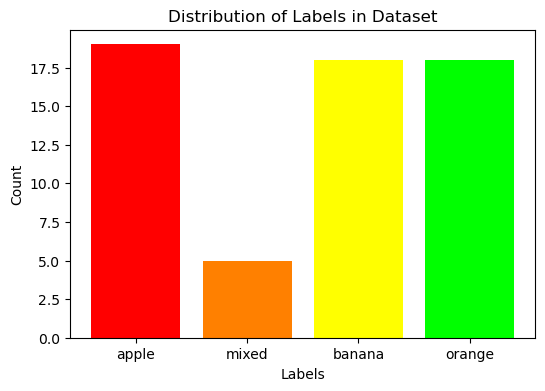

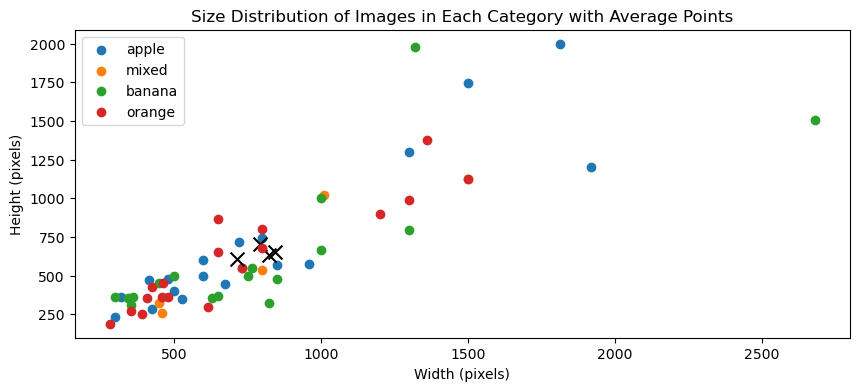

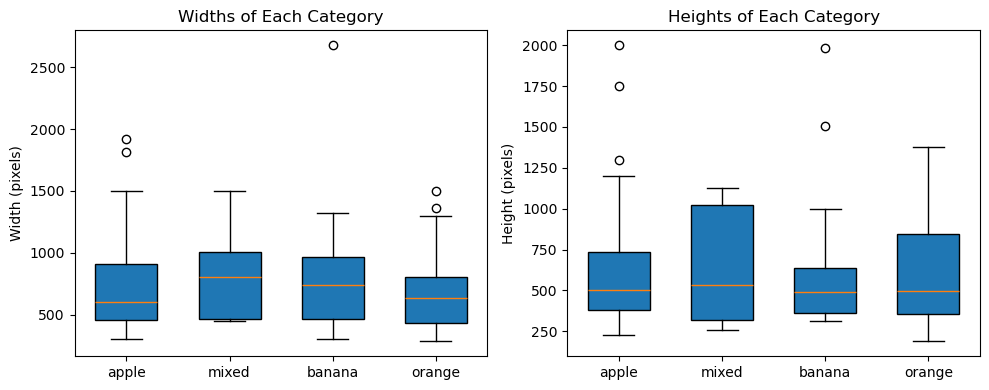

Epoch 1/15
8/8 [==============================] - 17s 2s/step - loss: 2.3234 - accuracy: 0.3417 - val_loss: 1.2974 - val_accuracy: 0.4833
Epoch 2/15
8/8 [==============================] - 14s 2s/step - loss: 1.2037 - accuracy: 0.5042 - val_loss: 0.9612 - val_accuracy: 0.7167
Epoch 3/15
8/8 [==============================] - 14s 2s/step - loss: 0.8253 - accuracy: 0.7042 - val_loss: 0.6899 - val_accuracy: 0.7500
Epoch 4/15
8/8 [==============================] - 14s 2s/step - loss: 0.5426 - accuracy: 0.7833 - val_loss: 0.5940 - val_accuracy: 0.8667
Epoch 5/15
8/8 [==============================] - 14s 2s/step - loss: 0.2990 - accuracy: 0.8958 - val_loss: 0.5892 - val_accuracy: 0.8667
Epoch 6/15
8/8 [==============================] - 14s 2s/step - loss: 0.2837 - accuracy: 0.8917 - val_loss: 0.6259 - val_accuracy: 0.8833
Epoch 7/15
8/8 [==============================] - 14s 2s/step - loss: 0.2295 - accuracy: 0.9292 - val_loss: 0.4389 - val_accuracy: 0.8833
Epoch 8/15
8/8 [==================

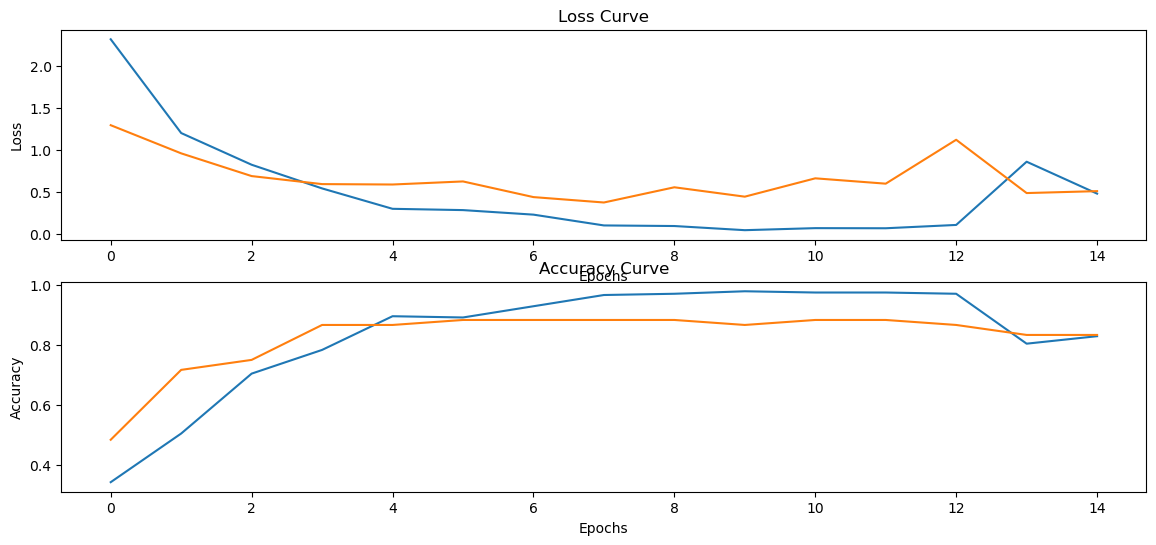

2/2 [==============================] - 1s 374ms/step - loss: 0.5100 - accuracy: 0.8333


In [40]:
#please alter this path to your own path
train_data_dir = 'train'
test_data_dir = 'test'
img_width = 256
img_height = 256

def main():
    model = create_model()
    print(model.summary())
    train_images, train_labels, train_unique_labels = read_img_data(train_data_dir, img_width, img_height)

    print("Color Analysis")
    analyze_dataset_color_histogram_non_white(train_images, train_labels, train_unique_labels)
    #analyze_dataset_color(train_images, labels, unique_labels)
    #analyze_dataset_color_3D(train_images, labels, unique_labels)
    
    x_train, y_train = prep_data(train_images, train_labels, train_unique_labels)
    test_images, test_labels, test_unique_labels = read_img_data(test_data_dir, img_width, img_height)
    x_test, y_test = prep_data(test_images, test_labels, test_unique_labels)
    train_model(model, x_train, y_train, x_test, y_test)
    #please alter this path to your own path
    #model.save(models/model.h5)
    model.save('E:/Code/Master/SA4110/CA/CA_models/Traditional_Classification_models/model_1.h5')
    #please alter this path to your own path
    #model = tf.keras.models.load_model(models/model.h5)
    model = tf.keras.models.load_model('E:/Code/Master/SA4110/CA/CA_models/Traditional_Classification_models/model_1.h5')

    model.evaluate(x=x_test/255, y=y_test)

if __name__ == "__main__":
    main()